In [1]:
from io import open
import re
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn.functional as F
import pandas as pd
import gensim
from nltk.tokenize import word_tokenize
import numpy as np
import time
import warnings
from IPython import display
import seaborn as sns
import matplotlib.pyplot  as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f' Device: {torch.cuda.get_device_name(0)}. Now using: {device.type}', '\n',
      f'Torch Version: {torch.version.__version__}')

 Device: NVIDIA GeForce RTX 4070 Ti. Now using: cuda 
 Torch Version: 2.2.1


In [2]:
def normalizeString(s, lang):
    s = s.lower().strip()
    if lang == 'lat':
        s = re.sub(r"[^a-zA-Z',.!?]+", r" ", s)
    elif lang == 'cyr':
        s = re.sub(r"[^Ёёа-яА-Я',.!?]+", r" ", s)
    else:
        pass
    return s

rus_eng = pd.read_csv('rus.txt', sep='\t+', header=None, usecols = [0,1], engine = 'python', names = ['ENG', 'RUS'])

max_sent_len = 50
rus_eng_len_filtered = rus_eng.loc[(rus_eng['ENG'].str.len() <= max_sent_len) & (rus_eng['RUS'].str.len() <= max_sent_len)].copy()

rus_eng_len_filtered['ENG_tok'] = rus_eng_len_filtered['ENG'].apply(lambda x: ['<START>'] + word_tokenize(normalizeString(x, 'lat'), language='english') + ['<END>'])
rus_eng_len_filtered['RUS_tok'] = rus_eng_len_filtered['RUS'].apply(lambda x: ['<START>'] + word_tokenize(normalizeString(x, 'cyr'), language='russian') + ['<END>'])

max_eng_len = max(rus_eng_len_filtered['ENG_tok'].apply(len))
max_rus_len = max(rus_eng_len_filtered['RUS_tok'].apply(len))

if max_eng_len >= max_rus_len:
    max_len = max_eng_len
else:
    max_len = max_rus_len

rus_eng_len_filtered['ENG_tok'] = rus_eng_len_filtered['ENG_tok'].apply(lambda x: x + ['<PAD>'] * (max_len - len(x)))
rus_eng_len_filtered['RUS_tok'] = rus_eng_len_filtered['RUS_tok'].apply(lambda x: x + ['<PAD>'] * (max_len - len(x)))

vector_size = 128
window = 6

def word2vec(words_column, vector_size, window):
    w2v = gensim.models.Word2Vec(sentences=words_column.tolist(), 
                                 vector_size=vector_size, 
                                 window=window,
                                 min_count=1, 
                                 workers=16)
    return w2v

w2v_eng = word2vec(rus_eng_len_filtered['ENG_tok'], vector_size, window)
w2v_rus = word2vec(rus_eng_len_filtered['RUS_tok'], vector_size, window)

In [3]:
rus_eng_len_filtered

,ENG,RUS,ENG_tok,RUS_tok
0,Go.,Марш!,"[<START>, go, ., <END>, <PAD>, <PAD>, <PAD>, <...","[<START>, марш, !, <END>, <PAD>, <PAD>, <PAD>,..."
1,Go.,Иди.,"[<START>, go, ., <END>, <PAD>, <PAD>, <PAD>, <...","[<START>, иди, ., <END>, <PAD>, <PAD>, <PAD>, ..."
2,Go.,Идите.,"[<START>, go, ., <END>, <PAD>, <PAD>, <PAD>, <...","[<START>, идите, ., <END>, <PAD>, <PAD>, <PAD>..."
3,Hi.,Здравствуйте.,"[<START>, hi, ., <END>, <PAD>, <PAD>, <PAD>, <...","[<START>, здравствуйте, ., <END>, <PAD>, <PAD>..."
4,Hi.,Привет!,"[<START>, hi, ., <END>, <PAD>, <PAD>, <PAD>, <...","[<START>, привет, !, <END>, <PAD>, <PAD>, <PAD..."
...,...,...,...,...
475332,Young children are incapable of abstract think...,Маленькие дети неспособны к абстрактному мышле...,"[<START>, young, children, are, incapable, of,...","[<START>, маленькие, дети, неспособны, к, абст..."
475333,Your lack of sleep will catch up with you some...,Недосыпание когда-нибудь тебе аукнется.,"[<START>, your, lack, of, sleep, will, catch, ...","[<START>, недосыпание, когда, нибудь, тебе, ау..."
475334,"Your plan is a good one, but mine is a better ...","Твой план хорош, а мой лучше.","[<START>, your, plan, is, a, good, one, ,, but...","[<START>, твой, план, хорош, ,, а, мой, лучше,..."
476688,Now that's a name I haven’t heard in a long time.,Этого имени я уже давно не слышал.,"[<START>, now, that, 's, a, name, i, haven, t,...","[<START>, этого, имени, я, уже, давно, не, слы..."


In [3]:
eng_pad_ind = w2v_eng.wv.key_to_index['<PAD>']
rus_pad_ind = w2v_rus.wv.key_to_index['<PAD>']
print(eng_pad_ind, rus_pad_ind)

0 0


In [4]:
class CustomDataset(Dataset):
    def __init__(self, df, eng_w2v_model, rus_w2v_model):
        self.df = df
        self.eng_w2v_model = eng_w2v_model
        self.rus_w2v_model = rus_w2v_model

    def __len__(self):
        return len(self.df)
    
    def embedding(self, sentence, model):
        return [model.wv[word] if word in model.wv else np.zeros(model.vector_size) for word in sentence]
    
    def indexesFromSentence(self, model, sentence):
        return [model.wv.key_to_index[word] for word in sentence]

    def __getitem__(self, idx):
        
        eng_sentence = self.df.iloc[idx]['ENG_tok']
        rus_sentence = self.df.iloc[idx]['RUS_tok']

        eng_embeddings = torch.tensor(np.array(self.embedding(eng_sentence, self.eng_w2v_model)), dtype = torch.float32)
        rus_embeddings = torch.tensor(np.array(self.embedding(rus_sentence, self.rus_w2v_model)), dtype = torch.float32)

        eng_indexes = torch.tensor(self.indexesFromSentence(self.eng_w2v_model, eng_sentence), dtype = torch.int)
        rus_indexes = torch.tensor(self.indexesFromSentence(self.rus_w2v_model, rus_sentence), dtype = torch.int)

        return eng_embeddings, rus_embeddings, eng_indexes, rus_indexes

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, input_size, rnn_type='GRU', num_layers = 1):
        super(EncoderRNN, self).__init__()
        self.rnn_type = rnn_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, num_layers = num_layers)
        else:
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers = num_layers) 

    def forward(self, input, hidden): 
        output, hidden = self.rnn(input, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        init_hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        if self.rnn_type == 'GRU':
            return init_hidden
        else:
            return (init_hidden, init_hidden)

In [6]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, dec_input_size, vocab_size, rnn_type='GRU', num_layers = 1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.vocab_size = vocab_size

        if rnn_type == 'GRU':
            self.rnn = nn.GRU(dec_input_size, hidden_size, batch_first=True, num_layers = num_layers)
        else:
            self.rnn = nn.LSTM(dec_input_size, hidden_size, batch_first=True, num_layers = num_layers)
            
        self.out = nn.Linear(hidden_size, vocab_size)
        # self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):

        output, hidden = self.rnn(input, hidden)
        output = self.out(output)
        # output = self.softmax(self.out(output))
        return output, hidden

    def initHidden(self, batch_size):
        init_hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        if self.rnn_type == 'GRU':
            return init_hidden
        else:
            return (init_hidden, init_hidden)

In [ ]:
test_subset = rus_eng_len_filtered.sample(frac = .1)

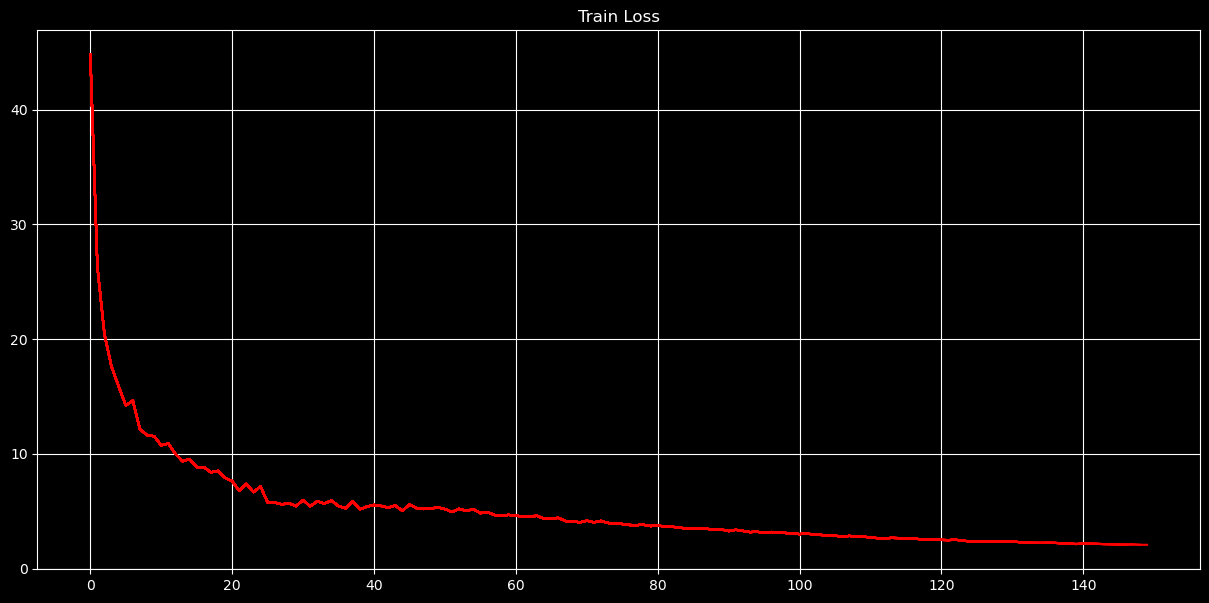

Epoch 149 -- Epoch Loss: 2.0761 -- Learning Rate: 0.000366 -- Teacher Forcing: 0.100 -- Time: 239.12s


In [8]:
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15, 7))
ax.set_title('Train Loss')
ax.grid()

dataset = rus_eng_len_filtered
batch_size = 512
hidden_size = 512
teacher_forcing_ratio = 0.5
learning_rate = 0.001
n_epochs = 150
num_layers = 2
direction = 'rus to eng'
rnn_type = 'lstm'
max_len = max_len
gamma = 0.99

if direction == 'rus to eng':
    vocab_size = len(w2v_eng.wv.index_to_key)
    source_w2v = w2v_rus
    target_w2v = w2v_eng
else:
    vocab_size = len(w2v_rus.wv.index_to_key)
    source_w2v = w2v_eng
    target_w2v = w2v_rus

dataset = CustomDataset(dataset, w2v_eng, w2v_rus)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

encoder = EncoderRNN(rnn_type=rnn_type, hidden_size=hidden_size, input_size=vector_size, num_layers = num_layers).to(device)
decoder = DecoderRNN(rnn_type=rnn_type, hidden_size=hidden_size, dec_input_size=vector_size, num_layers = num_layers, vocab_size = vocab_size).to(device)
criterion = nn.CrossEntropyLoss() # С ignore_index=0 функция потерь выдает NaN на последних батчах. Так и не разобрался, как исправить

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
encoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(encoder_optimizer, gamma=gamma)
decoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(decoder_optimizer, gamma=gamma)

# encoder.load_state_dict(torch.load('encoder_weights.pth', weights_only=True))
# encoder_optimizer.load_state_dict(torch.load('encoder_optimizer.pth', weights_only=True))
# decoder.load_state_dict(torch.load('decoder_weights.pth', weights_only=True))
# decoder_optimizer.load_state_dict(torch.load('decoder_optimizer.pth', weights_only=True))
# encoder_optimizer.param_groups[0]['lr'] = 0.0005
# decoder_optimizer.param_groups[0]['lr'] = 0.0005

losses = []

for ep in range(n_epochs):

    if ep >= 25:
        teacher_forcing_ratio = max(.1, .75 - ep / n_epochs)

    start = time.time()
    epoch_loss = 0.

    encoder.train(True)
    decoder.train(True)

    for batch_n, batch in enumerate(data_loader):
        encoder_hidden = encoder.initHidden(batch_size)
        eng_embeddings, rus_embeddings, eng_indexes, rus_indexes = batch

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        if direction == 'rus to eng':
            source_batch = rus_embeddings.to(device)
            target_batch = eng_embeddings.to(device)
            source_indexes = rus_indexes
            target_indexes= eng_indexes.to(device)

        else:
            source_batch = eng_embeddings.to(device)
            target_batch = rus_embeddings.to(device)
            source_indexes = eng_indexes
            target_indexes = rus_indexes.to(device)
    
        encoder_out, encoder_hidden = encoder(source_batch, encoder_hidden)

        decoder_hidden = encoder_hidden
        decoder_input = target_batch[:,0,:].unsqueeze(1)
        
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

        batch_loss = 0.
        if use_teacher_forcing:
            for di in range(max_len-1):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
                current_targets = target_indexes[:, di].unsqueeze(1).type(torch.LongTensor).to(device)
                loss_step = criterion(decoder_output.view(-1, vocab_size), current_targets.flatten())
                batch_loss += loss_step
                decoder_input = target_batch[:,di+1,:].unsqueeze(1)
        else:
            for di in range(max_len-1):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                _, topi = decoder_output.topk(1, dim=2)
                word_indexes = topi.squeeze().cpu().numpy()
                tgt_enbeddings = []
                for index in word_indexes:
                    tgt_enbeddings.append(target_w2v.wv[index])
                decoder_input = torch.tensor(tgt_enbeddings).unsqueeze(1).to(device)
                current_targets = target_indexes[:, di].type(torch.LongTensor).unsqueeze(1).to(device)
                loss_step = criterion(decoder_output.view(-1, vocab_size), current_targets.flatten())
                batch_loss += loss_step

        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

        batch_loss = batch_loss / batch_size       
        epoch_loss += batch_loss.item()
        encoder_optimizer.step()
        decoder_optimizer.step()

    if ep >= 50:
        encoder_scheduler.step()
        decoder_scheduler.step()
    last_lr = encoder_optimizer.param_groups[0]['lr']
    losses.append(epoch_loss)
    sns.lineplot(losses, c='red', ax = ax)
    display.display(fig, clear=True)
    plt.close()

    print(f'Epoch {ep} -- Epoch Loss: {epoch_loss:.4f} -- Learning Rate: {last_lr:.6f} -- Teacher Forcing: {teacher_forcing_ratio:.3f} -- Time: {time.time() - start:.2f}s')

In [9]:
last_encoder_state = encoder.state_dict()
last_encoder_optim_state = encoder_optimizer.state_dict()
last_decoder_state = decoder.state_dict()
last_decoder_optim_state = decoder_optimizer.state_dict()

torch.save(encoder.state_dict(), 'encoder_weights.pth')
torch.save(encoder_optimizer.state_dict(), 'encoder_optimizer.pth')
torch.save(decoder.state_dict(), 'decoder_weights.pth')
torch.save(decoder_optimizer.state_dict(), 'decoder_optimizer.pth')

In [ ]:

def translate(phrase, encoder, decoder, w2v_source_model, w2v_target_model, lang):
    if lang == 'russian':
        charset = 'cyr'
        language = 'russian'
    else:
        charset = 'lat'
        language = 'russian'
    outputs = []
    tokenized_phrase = word_tokenize(normalizeString(phrase, charset), language=language) + ['<END>']
    phrase_embeddings = torch.tensor(
    [w2v_source_model.wv[word] if word in w2v_source_model.wv else np.zeros(w2v_source_model.vector_size) for word in tokenized_phrase], 
    dtype = torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        encoder_hidden = encoder.initHidden(1)
        _, encoder_hidden = encoder(phrase_embeddings, encoder_hidden)
        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor(w2v_eng.wv['<START>']).view((1, 1, 128)).to(device)
        for i in range(10):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topi = decoder_output.topk(1, dim=2)
            word_index = topi.item()
            word = w2v_target_model.wv.index_to_key[word_index]
            outputs.append(word)
            if word in ['<END>','<PAD>']:
                break
            decoder_input = torch.tensor(w2v_target_model.wv[word]).view((1, 1, 128)).to(device)
    print(' '.join(outputs))

In [51]:
phrase = 'здесь никто не живёт'
translate(phrase, encoder, decoder, w2v_rus, w2v_eng, 'russian')


nobody here lives here . <END>
